
<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">用户画像数据分析报告</h2>
<p style="font-size:15px;line-height:1.6em">本报告对 Taobao 用户画像数据集进行了完整的 EDA，包括缺失值分析、分布图、偏度指标、特征工程（截断、缺失填充）、TopN 类别统计等，用于支持后续 CTR 模型的数据建模。</p>



<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">数据读取与预处理</h2>
<p style="font-size:15px;line-height:1.6em">加载原始行为数据与用户画像数据，同时清洗列名，准备后续分析。</p>


user_profile
This data set covers the basic information of 1060000 users in raw_sample.. Field description is as follows:
(1) userid: user ID;
(2) cms_segid: Micro group ID;
(3) cms_group_id: cms_group_id;
(4) final_gender_code: gender 1 for male , 2 for female
(5) age_level: age_level
(6) pvalue_level: Consumption grade, 1: low,  2: mid,  3: high
(7) shopping_level: Shopping depth, 1: shallow user, 2: moderate user, 3: depth user
(8) occupation: Is the college student 1: yes, 0: no?
(9) new_user_class_level: City level
(10) behavior_log

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')
import os


<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">数据基本结构分析</h2>
<p style="font-size:15px;line-height:1.6em">查看数据的行列数、字段类型、前几行样本，初步了解数据整体情况。</p>


In [2]:
# ========= 1. Load Data =========
os.chdir('/Users/nf/Desktop/Taobao')
raw_df = pd.read_csv('raw_sample.csv')
user_df = pd.read_csv('user_profile.csv')

In [3]:
print(user_df.columns.tolist())
user_df.columns = user_df.columns.str.strip()

['userid', 'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level', 'pvalue_level', 'shopping_level', 'occupation', 'new_user_class_level ']


In [4]:
# ========= 2. Basic Overview =========
print(f"User Profile Data Shape: {user_df.shape}")
print("\nColumn Types:\n", user_df.dtypes)
print("\nSample Rows:\n", user_df.head())

User Profile Data Shape: (1061768, 9)

Column Types:
 userid                    int64
cms_segid                 int64
cms_group_id              int64
final_gender_code         int64
age_level                 int64
pvalue_level            float64
shopping_level            int64
occupation                int64
new_user_class_level    float64
dtype: object

Sample Rows:
    userid  cms_segid  cms_group_id  final_gender_code  age_level  \
0     234          0             5                  2          5   
1     523          5             2                  2          2   
2     612          0             8                  1          2   
3    1670          0             4                  2          4   
4    2545          0            10                  1          4   

   pvalue_level  shopping_level  occupation  new_user_class_level  
0           NaN               3           0                   3.0  
1           1.0               3           1                   2.0  
2           2.0 

输出数据维度、数据类型及前几行，了解数据大致结构。多了1768条数据？


<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">缺失值分析与可视化</h2>
<p style="font-size:15px;line-height:1.6em">统计各字段缺失值数量与比例，并通过热力图展示缺失模式。</p>



=== Missing Value Summary ===
                      MissingCount  MissingRatio
userid                           0      0.000000
cms_segid                        0      0.000000
cms_group_id                     0      0.000000
final_gender_code                0      0.000000
age_level                        0      0.000000
pvalue_level                575917      0.542413
shopping_level                   0      0.000000
occupation                       0      0.000000
new_user_class_level        344920      0.324854


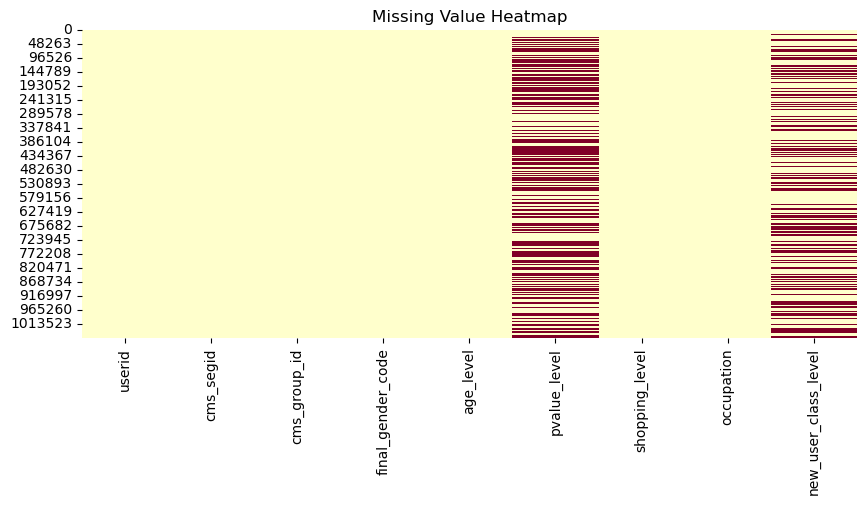

In [5]:
# ========= 3. Missing Values =========
missing = user_df.isnull().sum()
missing_ratio = missing / len(user_df)

missing_summary = pd.DataFrame({
    "MissingCount": missing,
    "MissingRatio": missing_ratio
})
print("\n=== Missing Value Summary ===")
print(missing_summary)

# Viusual
plt.figure(figsize=(10, 4))
sns.heatmap(user_df.isnull(), cbar=False, cmap="YlOrRd")
plt.title("Missing Value Heatmap")
plt.show()

计算每列的缺失值数量及比例，构建缺失统计表并可视化缺失值热力图。new_user_class_level （城市水平，一二线城市？）和pvalue_level （个人消费水平？）均有较大缺失，pvalue_level: 缺失 575,917 行，占比约 54%，new_user_class_level: 缺失 344,920 行，占比约 32%


<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">唯一值与重复值分析</h2>
<p style="font-size:15px;line-height:1.6em">分析每个字段的唯一取值数量，检查是否存在重复数据行。</p>


In [6]:
# ========= 4. Unique Values & Duplicates =========
unique_values = user_df.nunique()
duplicate_count = user_df.duplicated().sum()

print("\n=== Unique Values Per Column ===")
print(unique_values)
print(f"\nDuplicate Rows: {duplicate_count}")


=== Unique Values Per Column ===
userid                  1061768
cms_segid                    97
cms_group_id                 13
final_gender_code             2
age_level                     7
pvalue_level                  3
shopping_level                3
occupation                    2
new_user_class_level          4
dtype: int64

Duplicate Rows: 0


检查是否有常数列、异常唯一值数。表明有1061768个用户
识别重复数据，防止冗余干扰建模。且没有重复的数据，每个用户对应一条数据


<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">描述性统计与偏度指标</h2>
<p style="font-size:15px;line-height:1.6em">生成各字段的均值、中位数、极值、分位数，同时计算偏度用于判断数据分布形态。</p>


In [7]:
# ========= 5. Descriptive Statistics + Skewness =========
desc = user_df.describe().T
desc["skewness"] = user_df.skew(numeric_only=True)
print("\n=== Descriptive Stats + Skewness ===")
print(desc)


=== Descriptive Stats + Skewness ===
                          count           mean            std  min        25%  \
userid                1061768.0  571310.408876  329502.062037  1.0  286245.75   
cms_segid             1061768.0      15.129979      25.355029  0.0       0.00   
cms_group_id          1061768.0       5.542412       3.178516  0.0       3.00   
final_gender_code     1061768.0       1.644445       0.478681  1.0       1.00   
age_level             1061768.0       3.410641       1.227458  0.0       3.00   
pvalue_level           485851.0       1.759850       0.581303  1.0       1.00   
shopping_level        1061768.0       2.716854       0.586104  1.0       3.00   
occupation            1061768.0       0.056231       0.230367  0.0       0.00   
new_user_class_level   716848.0       2.516379       0.928334  1.0       2.00   

                           50%        75%        max  skewness  
userid                571455.5  854666.25  1141729.0  0.001189  
cms_segid            

获取基本统计信息（均值、中位数、分位数、最大最小值）；
添加偏度指标判断数据分布形态（对称/偏斜）。
userid	~0	近似对称分布，用户编号均匀分布
cms_segid	1.65	右偏：大部分用户集中在低编号群体，少数高编号拉高均值
cms_group_id	0.48	轻微右偏，说明分布略偏向低值群体
final_gender_code	-0.60	左偏：说明女性（2）数量多于男性（1）
age_level	-0.09	接近对称分布，说明各年龄层相对均衡
pvalue_level	0.08	非常接近 0，表示消费力等级分布非常对称, 有缺失
shopping_level	-1.94	强烈左偏，大多数为深度购物用户（level 3）
occupation	3.85	极度右偏，大部分用户为非学生（0），只有少部分为学生（1）
new_user_class_level	0.26	略偏右，说明较多用户来自中低等级城市，有缺失


<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">变量分布图绘制</h2>
<p style="font-size:15px;line-height:1.6em">离散变量绘制 countplot，连续变量绘制 histplot+kde，直观展示分布特征。</p>


Discrete Columns: ['cms_group_id', 'final_gender_code', 'age_level', 'pvalue_level', 'shopping_level', 'occupation', 'new_user_class_level']
Continuous Columns: ['userid', 'cms_segid']


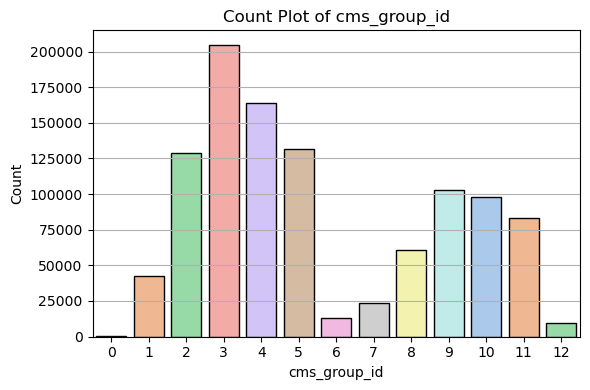

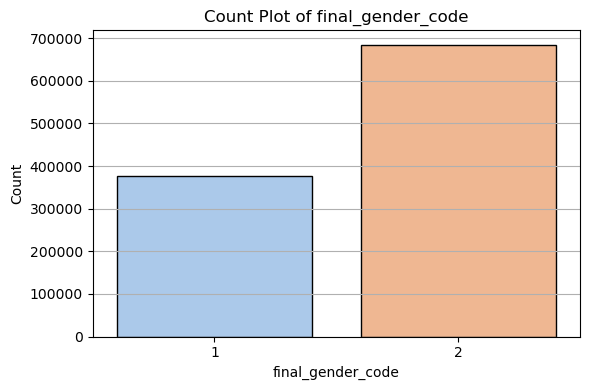

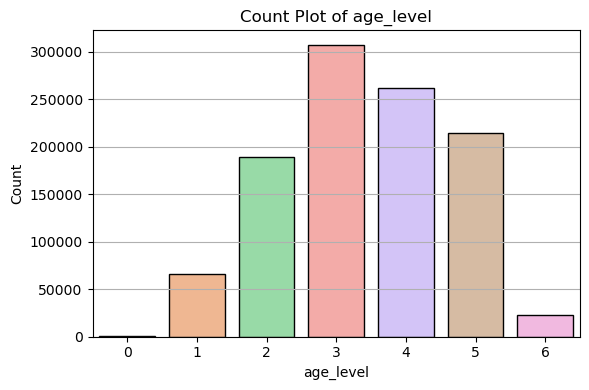

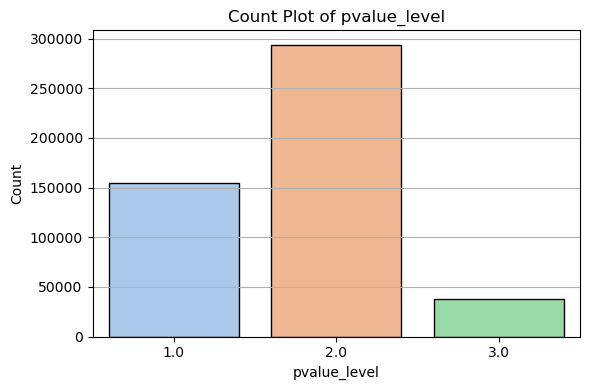

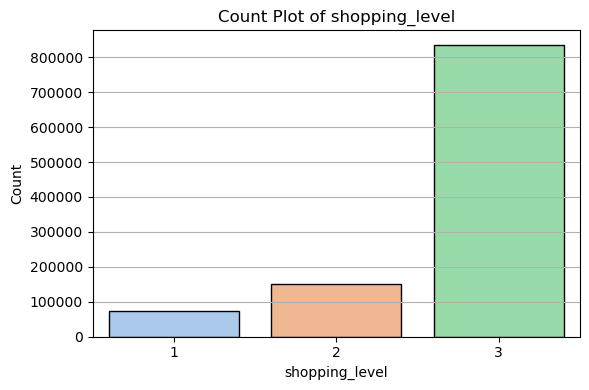

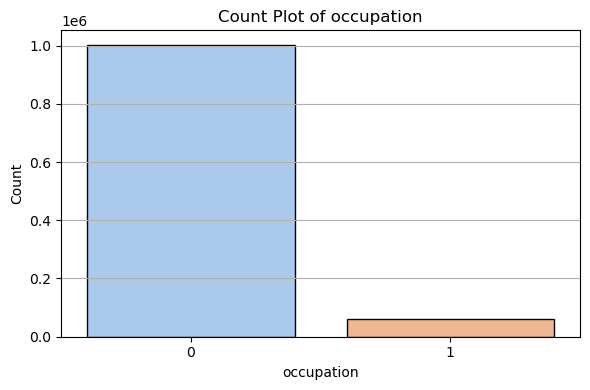

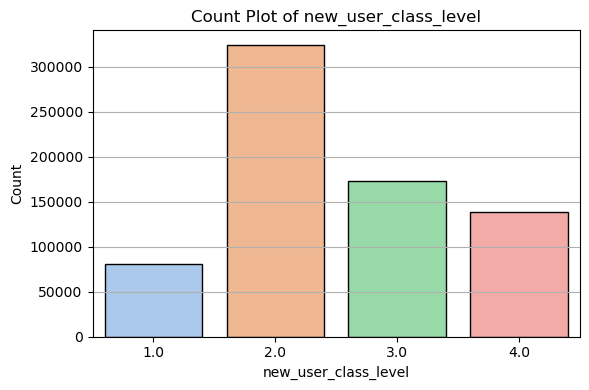

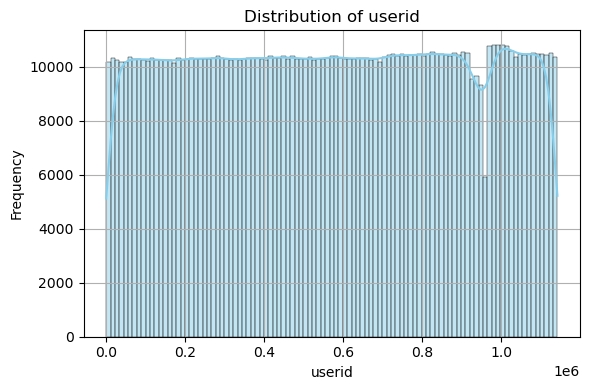

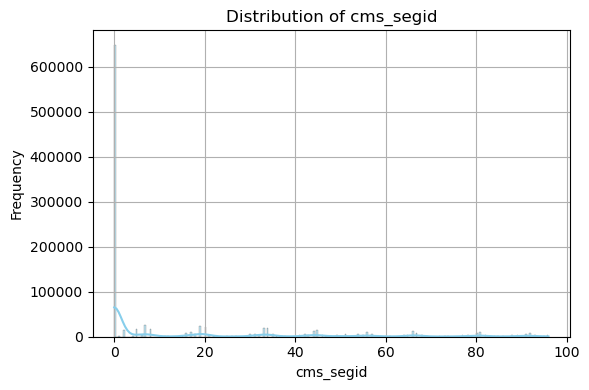

In [8]:
# ========= 6. Distribution Plots =========
# 1. Determine whether each column is discrete or continuous
# If the number of unique values is less than a certain threshold(e.g. 20), it is treated as a discrete variable
discrete_cols = [col for col in user_df.columns if user_df[col].nunique() < 20]
continuous_cols = [col for col in user_df.columns if user_df[col].nunique() >= 20]

print(f"Discrete Columns: {discrete_cols}")
print(f"Continuous Columns: {continuous_cols}")

# 2. Plot discrete variables (countplot)
for col in discrete_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=user_df, x=col, palette='pastel', edgecolor='black')
    plt.title(f'Count Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# 3. Plot continuous variables (histplot + kde)
for col in continuous_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(user_df[col], kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

区分离散变量与连续变量；离散变量用 countplot，连续变量用 histplot + kde。
cms_group_id, final_gender_code, age_level 等离散变量
final_gender_code: 女 > 男，对应偏度为负；
shopping_level: 大量为 level=3，对应强左偏；
occupation: 非学生人数远远高于学生，对应右偏 3.85；
new_user_class_level: 城市等级分布大致集中在 level 2 和 3，均衡性较好。
userid, cms_segid连续变量
userid 分布近似均匀，合理。
cms_segid 分布严重右偏，大多数集中在小于 5 的 segment。


<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">特征相关性热力图</h2>
<p style="font-size:15px;line-height:1.6em">通过计算数值型变量间的 Pearson 相关系数并绘制热力图，辅助后续特征选择。</p>


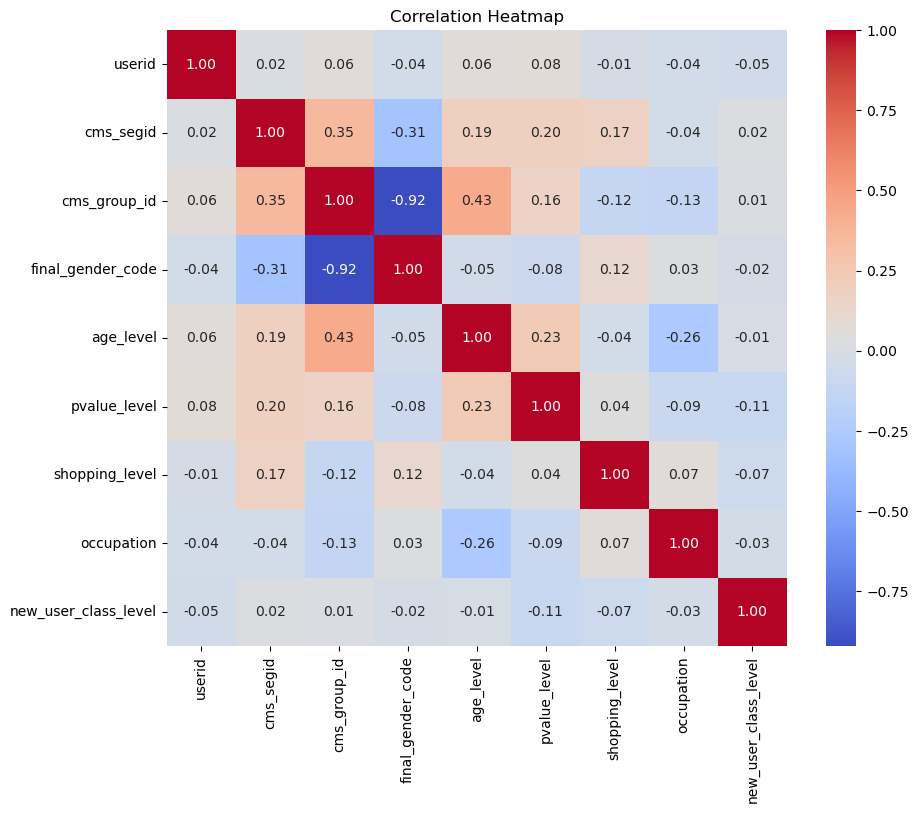

In [9]:
# ========= 7. Correlation Heatmap (Optional) =========
plt.figure(figsize=(10, 8))
corr = user_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

计算所有数值型变量的相关性矩阵并可视化；
cms_group_id 与 final_gender_code 强负相关 -0.92
→ 说明 group_id 划分可能和性别特征设计有关；

age_level 与 cms_group_id 有正相关 0.43
→ 年龄越大越可能落入某些群体；

occupation 与 age_level 负相关 -0.26
→ 学生倾向于年龄小，非学生年龄更高；

其他变量间相关性整体偏弱


<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">特征工程：分位数截断与缺失值处理</h2>
<p style="font-size:15px;line-height:1.6em">进行极值截断（capping at P90），填补缺失值并生成缺失指标列。</p>


In [10]:
# ===== Feature engineering =====
# Quantiles
quantiles = user_df.quantile([0.05, 0.75, 0.9, 0.95])
p90 = quantiles.loc[0.9]
p95 = quantiles.loc[0.95]
print(f"P90 of User Profile: {p90}")
print(f"P95 of User Profile: {p95}")

P90 of User Profile: userid                  1029216.3
cms_segid                    57.0
cms_group_id                 10.0
final_gender_code             2.0
age_level                     5.0
pvalue_level                  2.0
shopping_level                3.0
occupation                    0.0
new_user_class_level          4.0
Name: 0.9, dtype: float64
P95 of User Profile: userid                  1085497.3
cms_segid                    80.0
cms_group_id                 11.0
final_gender_code             2.0
age_level                     5.0
pvalue_level                  3.0
shopping_level                3.0
occupation                    1.0
new_user_class_level          4.0
Name: 0.95, dtype: float64


cms_segid	57	80	超过 80 可能为极端用户群，建议 cap
userid	1029216	1085497	用户分布较均匀

In [11]:
# cap
for col in ['cms_segid', 'cms_group_id']:
    cap_value = user_df[col].quantile(0.9)
    user_df[f'{col}_capped'] = np.where(user_df[col] > cap_value, cap_value, user_df[col])

以 90% 分位数为上限，对超过该值的样本做截断处理（防止极端值对模型造成不稳定影响）。新增列如 cms_segid_capped,cms_group_id_capped，用于建模；截断值如 57 和 10 是合理上限。


<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">分类变量 Top10 分布统计</h2>
<p style="font-size:15px;line-height:1.6em">对主要离散特征提取 Top10 分组频次，分析类别倾斜与特征稀疏性。</p>


In [12]:
# top10 group
for col in ['age_level', 'cms_group_id', 'cms_segid', 'pvalue_level', 'shopping_level']:
    print(f"\nTop 10 of {col}:")
    print(user_df[col].value_counts().head(10))



Top 10 of age_level:
age_level
3    307340
4    261751
5    214462
2    189617
1     65568
6     22529
0       501
Name: count, dtype: int64

Top 10 of cms_group_id:
cms_group_id
3     204702
4     163592
5     131440
2     129061
9     102638
10     98159
11     83022
8      60556
1      42297
7      23271
Name: count, dtype: int64

Top 10 of cms_segid:
cms_segid
0     648381
7      24996
19     23976
20     22053
34     18720
33     18178
8      17698
5      17423
45     13920
2      13545
Name: count, dtype: int64

Top 10 of pvalue_level:
pvalue_level
2.0    293656
1.0    154436
3.0     37759
Name: count, dtype: int64

Top 10 of shopping_level:
shopping_level
3    835745
2    151411
1     74612
Name: count, dtype: int64


查看分布最多的前 10 类别。


<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">数据填充后总体统计摘要</h2>
<p style="font-size:15px;line-height:1.6em">完成缺失值处理后的数据，再次生成 summary stats 总览，确认特征工程效果。</p>


In [13]:
# Copy
user_df_miss = user_df.copy()

# Fill missing value by mode
for col in ['pvalue_level', 'new_user_class_level']:
    user_df_miss[f'{col}_missing'] = user_df[col].isnull().astype(int)
    mode_val = user_df[col].mode(dropna=True)[0]
    user_df[col].fillna(mode_val, inplace=True)

print("\nSample Rows:\n", user_df_miss.head())


Sample Rows:
    userid  cms_segid  cms_group_id  final_gender_code  age_level  \
0     234          0             5                  2          5   
1     523          5             2                  2          2   
2     612          0             8                  1          2   
3    1670          0             4                  2          4   
4    2545          0            10                  1          4   

   pvalue_level  shopping_level  occupation  new_user_class_level  \
0           NaN               3           0                   3.0   
1           1.0               3           1                   2.0   
2           2.0               3           0                   NaN   
3           NaN               1           0                   NaN   
4           NaN               3           0                   NaN   

   cms_segid_capped  cms_group_id_capped  pvalue_level_missing  \
0               0.0                  5.0                     1   
1               5.0          

miss的0表示原本是有数据的，1是missing的，添加了缺失值

In [14]:
# Summary after fill
summary_stats = pd.DataFrame({
    'Min': user_df_miss.min(numeric_only=True),
    'Max': user_df_miss.max(numeric_only=True),
    'P90': user_df_miss.quantile(0.9),
    'P75': user_df_miss.quantile(0.75),
    'Distinct': user_df_miss.nunique()
})

print(summary_stats )

                              Min        Max        P90        P75  Distinct
userid                        1.0  1141729.0  1029216.3  854666.25   1061768
cms_segid                     0.0       96.0       57.0      20.00        97
cms_group_id                  0.0       12.0       10.0       9.00        13
final_gender_code             1.0        2.0        2.0       2.00         2
age_level                     0.0        6.0        5.0       4.00         7
pvalue_level                  1.0        3.0        2.0       2.00         3
shopping_level                1.0        3.0        3.0       3.00         3
occupation                    0.0        1.0        0.0       0.00         2
new_user_class_level          1.0        4.0        4.0       3.00         4
cms_segid_capped              0.0       57.0       57.0      20.00        58
cms_group_id_capped           0.0       10.0       10.0       9.00        11
pvalue_level_missing          0.0        1.0        1.0       1.00         2

shopping_level	3	3	3	完全符合 1~3 离散等级
cms_segid	96	57	97	偏态较强，cap 后变为 capped 列
occupation	1	0	2	二分类，偏向 0（非学生）
*_missing	0/1	-	2	成功生成缺失标志列

<h2 style="color:#2C3E50;font-size:20px;border-bottom:2px solid #ccc;padding-bottom:3px;">Merge Raw sample和User profile
</h2>

In [15]:
# Merge：raw_sample LEFT JOIN user_profile on user id
merged_df = raw_df.merge(user_df, how='left', left_on='user', right_on='userid')
print("Merged Data Shape:", merged_df.shape)
print("\nSample Rows:\n", merged_df.head())

Merged Data Shape: (26557961, 17)

Sample Rows:
      user  time_stamp  adgroup_id          pid  nonclk  clk    userid  \
0  581738  1494137644           1  430548_1007       1    0  581738.0   
1  449818  1494638778           3  430548_1007       1    0       NaN   
2  914836  1494650879           4  430548_1007       1    0  914836.0   
3  914836  1494651029           5  430548_1007       1    0  914836.0   
4  399907  1494302958           8  430548_1007       1    0  399907.0   

   cms_segid  cms_group_id  final_gender_code  age_level  pvalue_level  \
0        0.0           8.0                1.0        2.0           2.0   
1        NaN           NaN                NaN        NaN           NaN   
2        0.0           5.0                2.0        5.0           2.0   
3        0.0           5.0                2.0        5.0           2.0   
4        0.0           5.0                2.0        5.0           2.0   

   shopping_level  occupation  new_user_class_level  cms_segid_capp

In [16]:
# Missing Values
missing_megerd = merged_df.isnull().sum()
ratio_merged = missing_megerd / len(merged_df)

missing_merged_summary = pd.DataFrame({
    "MissingCount": missing_megerd,
    "MissingRatio": ratio_merged
}).sort_values(by='MissingCount', ascending=False)

print("\n=== Missing Value Summary after Merged ===")
print(missing_merged_summary)



=== Missing Value Summary after Merged ===
                      MissingCount  MissingRatio
cms_group_id               1528526      0.057554
final_gender_code          1528526      0.057554
cms_segid_capped           1528526      0.057554
new_user_class_level       1528526      0.057554
occupation                 1528526      0.057554
shopping_level             1528526      0.057554
pvalue_level               1528526      0.057554
age_level                  1528526      0.057554
cms_group_id_capped        1528526      0.057554
cms_segid                  1528526      0.057554
userid                     1528526      0.057554
time_stamp                       0      0.000000
clk                              0      0.000000
nonclk                           0      0.000000
pid                              0      0.000000
adgroup_id                       0      0.000000
user                             0      0.000000


raw_sample 中行为记录来自约 114 万个用户
user_profile 提供的是约 106 万个用户的画像
说明：至少有 8 万个用户在行为表中有记录但在画像表中没有信息
由于行为表中一个 user 有多条记录，最终导致：
合并后有约 152 万条样本缺失画像字段
缺失率为 5.75%

In [17]:
# Fill missing
for col in ['pvalue_level', 'new_user_class_level']:
    merged_df[f'{col}_missing'] = merged_df[col].isnull().astype(int)
    mode_val = merged_df[col].mode(dropna=True)[0]
    merged_df[col].fillna(mode_val, inplace=True)

# Capping
for col in ['cms_segid', 'cms_group_id']:
    p90 = merged_df[col].quantile(0.9)
    merged_df[f'{col}_capped'] = np.where(merged_df[col] > p90, p90, merged_df[col])


In [18]:
# Feature columns: user + capped + missing
feature_cols = [
    'cms_segid_capped', 'cms_group_id_capped',
    'final_gender_code', 'age_level', 'pvalue_level', 'shopping_level', 
    'occupation', 'new_user_class_level',
    'pvalue_level_missing', 'new_user_class_level_missing'
]

X = merged_df[feature_cols]
y = merged_df['clk']   


In [19]:
# True CTR
ctr = merged_df['clk'].mean()
print(f"CTR：{ctr:.2%}")

CTR：5.14%


In [20]:
# List of user profile columns to groupby
user_profile_cols = [
    'final_gender_code', 'age_level', 'pvalue_level',
    'shopping_level', 'occupation', 'new_user_class_level'
]

# Groupby each and compute CTR
for col in user_profile_cols:
    print(f"\n=== CTR by {col} ===")
    print(merged_df.groupby(col)['clk'].mean().sort_index())



=== CTR by final_gender_code ===
final_gender_code
1.0    0.048354
2.0    0.052445
Name: clk, dtype: float64

=== CTR by age_level ===
age_level
0.0    0.052454
1.0    0.055237
2.0    0.051737
3.0    0.051057
4.0    0.049540
5.0    0.052162
6.0    0.056218
Name: clk, dtype: float64

=== CTR by pvalue_level ===
pvalue_level
1.0    0.051455
2.0    0.051610
3.0    0.047186
Name: clk, dtype: float64

=== CTR by shopping_level ===
shopping_level
1.0    0.053979
2.0    0.051728
3.0    0.051131
Name: clk, dtype: float64

=== CTR by occupation ===
occupation
0.0    0.051309
1.0    0.051521
Name: clk, dtype: float64

=== CTR by new_user_class_level ===
new_user_class_level
1.0    0.050427
2.0    0.051868
3.0    0.050602
4.0    0.051089
Name: clk, dtype: float64


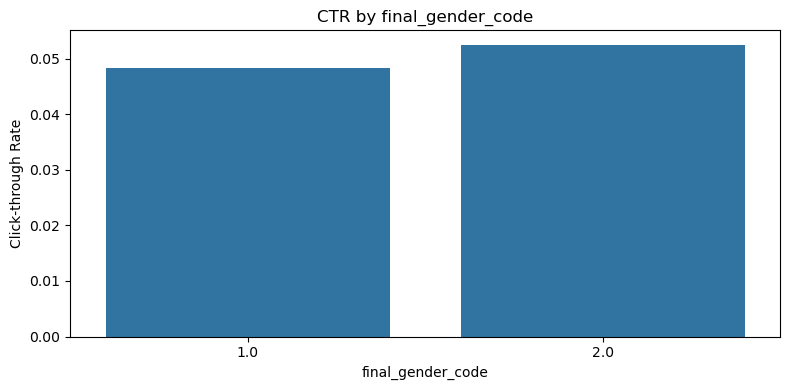

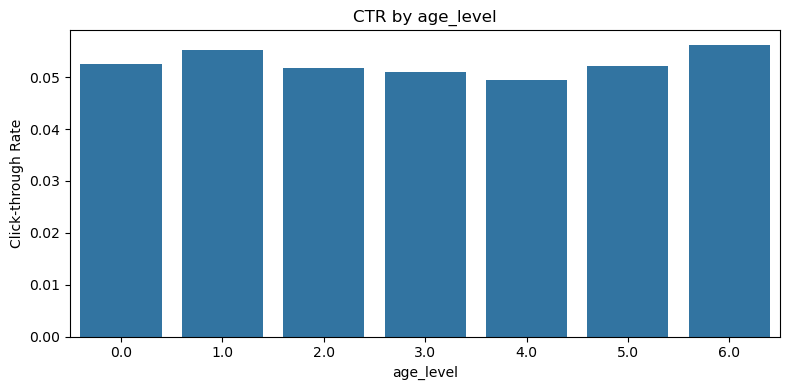

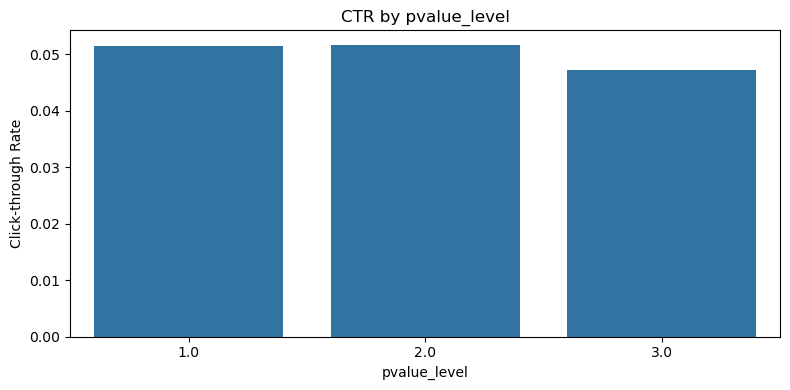

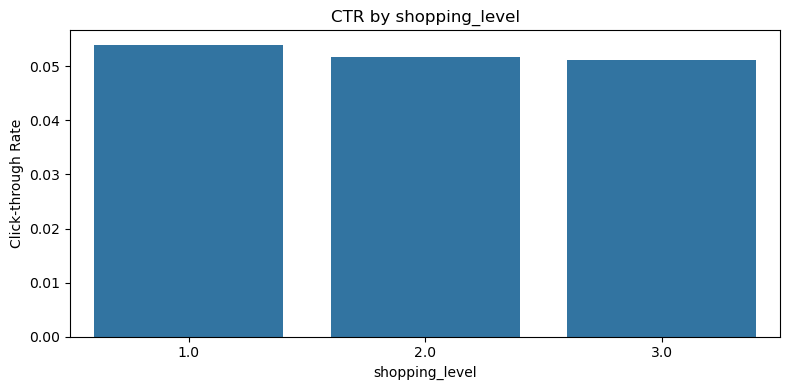

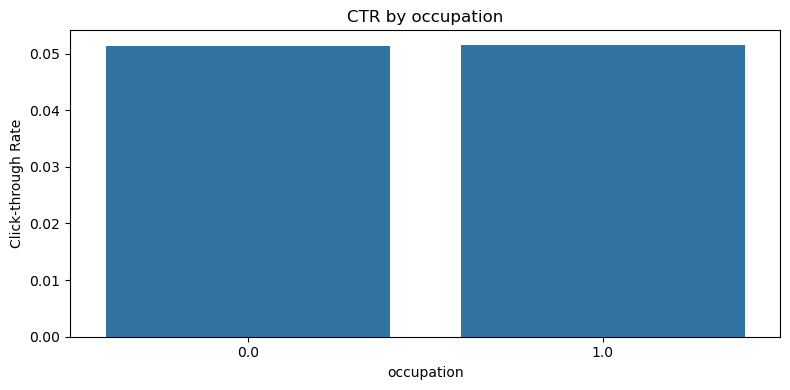

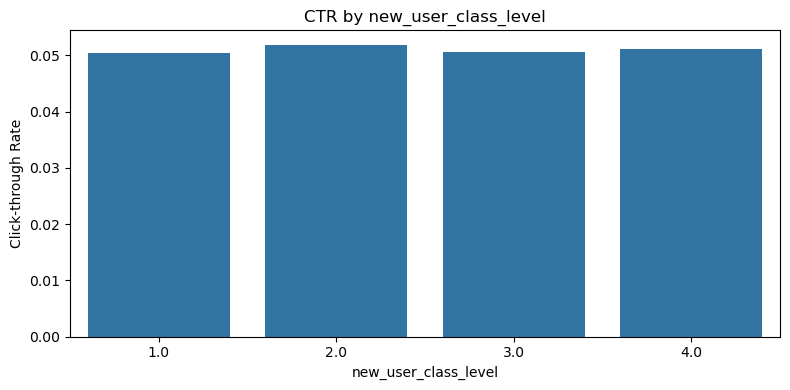

In [21]:
# Visual

for col in user_profile_cols:
    ctr_series = merged_df.groupby(col)['clk'].mean().sort_index()
    plt.figure(figsize=(8,4))
    sns.barplot(x=ctr_series.index, y=ctr_series.values)
    plt.title(f'CTR by {col}')
    plt.xlabel(col)
    plt.ylabel('Click-through Rate')
    plt.tight_layout()
    plt.show()


In [22]:
# Top 10 distribution
top10_summary = {}
for col in ['cms_group_id', 'age_level', 'pvalue_level', 'new_user_class_level']:
    if merged_df[col].nunique() < 30:
        top10_summary[col] = merged_df[col].value_counts(dropna=False).head(10)
top10_df = pd.concat(top10_summary, axis=1)
print(top10_df)

      cms_group_id  age_level  pvalue_level  new_user_class_level
3.0      5697945.0  7573614.0      895966.0             4620080.0
4.0      4387466.0  6406045.0           NaN             3706349.0
2.0      3683093.0  4567837.0    21544101.0            16350254.0
5.0      3031396.0  4652618.0           NaN                   NaN
10.0     2018579.0        NaN           NaN                   NaN
9.0      1875669.0        NaN           NaN                   NaN
11.0     1621222.0        NaN           NaN                   NaN
NaN      1528526.0  1528526.0           NaN                   NaN
1.0      1076559.0  1379703.0     4117894.0             1881278.0
8.0       884744.0        NaN           NaN                   NaN
6.0            NaN   440429.0           NaN                   NaN
0.0            NaN     9189.0           NaN                   NaN


### 特征构建

In [23]:
# User profile feature
user_profile_features = [
    'age_level', 'pvalue_level', 'shopping_level',
    'final_gender_code', 'cms_segid', 'cms_group_id',
    'occupation', 'new_user_class_level'
]

选择了8个典型的用户画像字段，用于反映用户的身份、消费行为和平台分群等特征

In [24]:
# Time feature
merged_df['hour'] = pd.to_datetime(merged_df['time_stamp'], unit='s').dt.hour
merged_df['day_of_week'] = pd.to_datetime(merged_df['time_stamp'], unit='s').dt.dayofweek
merged_df['is_weekend'] = merged_df['day_of_week'].isin([5,6]).astype(int)

time_features = ['hour', 'day_of_week', 'is_weekend']

假设点击行为与时间有关，比如深夜和周末用户更容易点击广告，因此添加了三个时间变量

In [25]:
# User behavior features
user_stats = merged_df.groupby('user')['clk'].agg(['count', 'sum'])
user_stats.columns = ['user_total_interactions', 'user_total_clicks']
user_stats['user_ctr'] = user_stats['user_total_clicks'] / user_stats['user_total_interactions']
merged_df = merged_df.merge(user_stats.reset_index(), on='user', how='left')

user_behavior_features = ['user_total_interactions', 'user_total_clicks', 'user_ctr']


count: 用户历史曝光次数（交互次数）
sum: 用户总点击数
user_ctr: 用户历史点击率
这部分捕捉的是用户过去的活跃程度和偏好，CTR能直接体现用户的点击倾向

In [26]:
# Summary
features = (
    user_profile_features +
    time_features +
    user_behavior_features
)

X = merged_df[features]  

# Fill missing values using mode for categorical, median for numeric
for col in features:
    if X[col].dtype == 'object' or str(X[col].dtype).startswith('int'):
        mode_val = X[col].mode(dropna=True)[0]
        X[col].fillna(mode_val, inplace=True)
    else:
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)

y = merged_df['clk']

拼接所有选中的特征变量，形成用于建模的特征矩阵 X
类别型变量用众数填补；
数值型变量用中位数填补；
确保输入模型的特征矩阵没有 NaN

### 特征编码

In [27]:
# Logistic Regression & XGBoost – One-Hot Encoding
from sklearn.preprocessing import OneHotEncoder

X_lr_xgb = pd.get_dummies(X, drop_first=True)

将离散变量转换为哑变量（如 gender → gender_1, gender_2），适用于线性模型和树模型。

In [28]:
# Embedding + MLP – Label Encoding
X_embed = X.copy()
for col in X_embed.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_embed[col] = le.fit_transform(X_embed[col].astype(str))


将离散特征转为整数索引，作为 embedding 的输入。

### 划分训练集

In [29]:
from sklearn.model_selection import train_test_split

X_train_lr_xgb, X_test_lr_xgb, y_train, y_test = train_test_split(X_lr_xgb, y, test_size=0.2, random_state=42, stratify=y)
X_train_embed, X_test_embed, _, _ = train_test_split(X_embed, y, test_size=0.2, random_state=42, stratify=y)


### 建模和评估

In [30]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_lr_xgb, y_train)
y_pred_lr = lr_model.predict_proba(X_test_lr_xgb)[:, 1]

print("Logistic Regression:")
print("AUC:", roc_auc_score(y_test, y_pred_lr))
print("LogLoss:", log_loss(y_test, y_pred_lr))


Logistic Regression:
AUC: 0.7844162584346837
LogLoss: 0.17868960893097782


线性模型作为 baseline，拟合能力有限，但具有可解释性。

In [31]:
# XGBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_lr_xgb, y_train)
y_pred_xgb = xgb_model.predict_proba(X_test_lr_xgb)[:, 1]

print("XGBoost:")
print("AUC:", roc_auc_score(y_test, y_pred_xgb))
print("LogLoss:", log_loss(y_test, y_pred_xgb))


XGBoost:
AUC: 0.7937732467192925
LogLoss: 0.1707868071615447


效果最优，说明在非线性建模与特征交叉方面表现优秀。

In [32]:
# Embedding + MLP 
# Step 1: Label Encoding with unseen value handling
X_embed = X.copy()
encoders = {}

for col in X_embed.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X_embed[col] = le.fit_transform(X_embed[col].astype(str))
    encoders[col] = le

# Train-test split
X_train_embed, X_test_embed, y_train, y_test = train_test_split(
    X_embed, y, test_size=0.2, random_state=42, stratify=y
)

# Handle unseen categories in test set
for col in X_test_embed.select_dtypes(include='object').columns:
    le = encoders[col]
    X_test_embed[col] = X_test_embed[col].map(
        lambda x: le.transform([x])[0] if x in le.classes_ else len(le.classes_)
    )


将样本按照 80/20 分为训练集和测试集，并保证点击比例一致（stratify）

In [39]:
import torch
import torch.nn as nn
import torch.utils.data as data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Step 2: Dataset Class
class CTRDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.long)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CTRDataset(X_train_embed, y_train)
test_dataset = CTRDataset(X_test_embed, y_test)

train_loader = data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=512)


In [40]:
# Step 3: Embedding MLP Model
class CTRModel(nn.Module):
    def __init__(self, X_df, emb_dim=8, hidden_dims=[64, 32]):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(int(X_df[col].max()) + 2, emb_dim) for col in X_df.columns
        ])
        self.mlp = nn.Sequential(
            nn.Linear(len(X_df.columns) * emb_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Linear(hidden_dims[1], 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        embs = [emb(x[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat(embs, dim=1)
        return self.mlp(x).squeeze()


In [41]:
# Step 4: Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CTRModel(X_embed).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

for epoch in range(5):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.1887
Epoch 2, Loss: 0.1216
Epoch 3, Loss: 0.2056
Epoch 4, Loss: 0.1962
Epoch 5, Loss: 0.2264


将嵌入后的用户画像和行为特征输入 MLP 模型，在训练过程中观察 loss 的收敛情况。第2轮时达到了最低点，此后略有反弹，提示我们可以通过增加 epoch 或正则化方法进一步提升模型泛化能力

In [42]:
# Evaluation
model.eval()
y_pred_nn, y_true_nn = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        pred = model(X_batch).cpu().numpy()
        y_pred_nn.extend(pred)
        y_true_nn.extend(y_batch.numpy())

print("Embedding + MLP:")
print("AUC:", roc_auc_score(y_true_nn, y_pred_nn))
print("LogLoss:", log_loss(y_true_nn, y_pred_nn))

Embedding + MLP:
AUC: 0.7927661042236087
LogLoss: 0.17103133217336827


Embedding + MLP 模型虽然略逊于 XGBoost，但其 AUC（0.7927）与 LogLoss（0.1710）非常接近，展示了深度学习模型在大规模稀疏类别特征建模上的潜力，尤其适用于广告推荐、搜索排序等任务场景。

#### 检查训练集和测试集尺寸

In [43]:
print("X_train_embed shape:", X_train_embed.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("\nX_test_embed shape:", X_test_embed.shape)
print("y_test distribution:\n", y_test.value_counts(normalize=True))


X_train_embed shape: (21246368, 14)
y_train distribution:
 clk
0    0.948563
1    0.051437
Name: proportion, dtype: float64

X_test_embed shape: (5311593, 14)
y_test distribution:
 clk
0    0.948563
1    0.051437
Name: proportion, dtype: float64


In [44]:
print("Train CTR (positive rate):", y_train.mean())
print("Test CTR (positive rate):", y_test.mean())


Train CTR (positive rate): 0.05143679145536781
Test CTR (positive rate): 0.05143673470463569


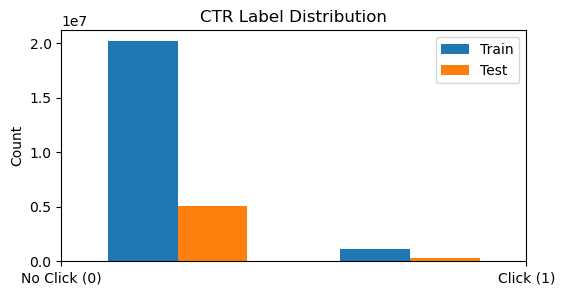

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.hist([y_train, y_test], bins=2, label=['Train', 'Test'], rwidth=0.6)
plt.xticks([0, 1], ['No Click (0)', 'Click (1)'])
plt.ylabel("Count")
plt.title("CTR Label Distribution")
plt.legend()
plt.show()
